In [5]:
import networkx as nx
import numpy as np
import pandas as pd

# for the explode statement; convert string to list
from ast import literal_eval

In [6]:
# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 
from scipy.sparse import csr_matrix

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5):

    adjacency = nx.to_scipy_sparse_array(G, nodelist=None, dtype=None, weight='weight', format='csr')
    adjacency = csr_matrix(adjacency) # fix to weird sknetwork-csr issue; comment out to troubleshoot
    
    names = np.array(list(G.nodes))
    
    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)
    
    pagerank = PageRank()
    scores = pagerank.fit_transform(adjacency)

    if show_names:
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width)
    
    else:
        
        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width)
    
    return SVG(image)

# Create Graph using Bipartite Projection on Arxiv Dataset

In [7]:
data = 'data/arxiv_network_science_data.csv'

df = pd.read_csv(data)
df['authors'] = df['authors'].apply(literal_eval)

df = df[['authors', 'title']]
df = df.explode('authors')
df.reset_index(drop=True, inplace=True)

# fix the & so that scikit-network stops crashing
df['authors'] = df['authors'].str.replace('&', 'and')
df['title'] = df['title'].str.replace('&', 'and')

df.head()

,authors,title
0,Dustin Nguyen,Neural ODEs as a discovery tool to characteriz...
1,Yuan-Sen Ting,Neural ODEs as a discovery tool to characteriz...
2,Todd A. Thompson,Neural ODEs as a discovery tool to characteriz...
3,Sebastian Lopez,Neural ODEs as a discovery tool to characteriz...
4,Laura A. Lopez,Neural ODEs as a discovery tool to characteriz...


In [8]:
from networkx.algorithms import bipartite

B = nx.from_pandas_edgelist(df, source='authors', target='title')
G = bipartite.projected_graph(B, df['authors'])

G = nx.k_core(G, 2) # no isolates or two-node groups

In [9]:
print(G)

Graph with 59260 nodes and 302588 edges


In [10]:
nx.density(G) # very sparse

0.00017233192168756068

In [11]:
degree_df = pd.DataFrame(G.degree)
degree_df.columns = ['node', 'degrees']

degree_df.head()

,node,degrees
0,Dustin Nguyen,4
1,Yuan-Sen Ting,36
2,Todd A. Thompson,4
3,Sebastian Lopez,4
4,Laura A. Lopez,4


<Axes: ylabel='Frequency'>

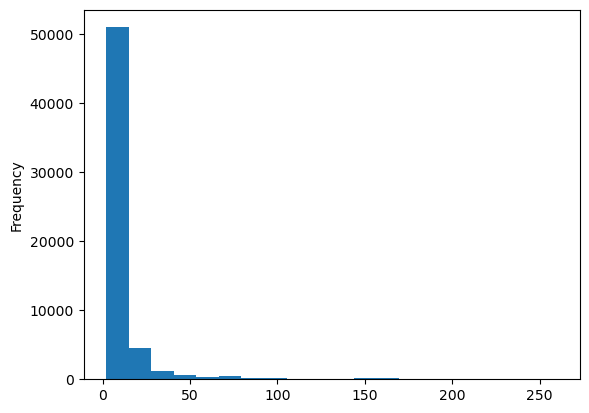

In [12]:
degree_df['degrees'].plot.hist(bins=20)

# Network Attack Simulation

Today, I am trying a very aggressive attack on a large collaboration network. The goal isn't just to disrupt the network but to be able to see the network structures that can withstand such an attack. In each loop, many nodes are removed at once to cause maximum disruption WITHOUT completely destroying the network

# Simulation 1: Iterative Attack

In [13]:
# need for iteration

def get_key_node_df(G):
    
    G = G.copy()
    
    cent_df = pd.DataFrame(nx.pagerank(G), index=[0]).T # cent = centrality

    cent_df.columns = ['pagerank'] # betweenness centrality
    cent_df.sort_values('pagerank', inplace=True, ascending=False)
    
    return cent_df

In [14]:
G1 = G.copy() # keep G for use with simulation 2

#draw_graph(nx.k_core(G1,3), show_names=False, node_size=3) # will take a long time

In [17]:
def remove_nodes(G, iterations=50, cut_size=500):
    
    results = {}
    
    G = G.copy()
    
    for i in range(iterations):
        
        results[i] = {}
        
        results[i]['nodes'] = len(G.nodes)
        results[i]['edges'] = len(G.edges)
        
        print('running loop: {}'.format(i))
    
        cent_df = get_key_node_df(G)

        drop_nodes = sorted(cent_df[0:cut_size].index)
        
        #print('removing key nodes: {}'.format(drop_nodes))

        G.remove_nodes_from(drop_nodes)

        G = nx.k_core(G, 2) # no isolates or two-node groups

        print(G)
        
        print()
        print('---------------')
        print()
        
    return G, results

In [18]:
G1, results = remove_nodes(G1, iterations=50)

running loop: 0
Graph with 57667 nodes and 283092 edges

---------------

running loop: 1
Graph with 56456 nodes and 270366 edges

---------------

running loop: 2
Graph with 55444 nodes and 258832 edges

---------------

running loop: 3
Graph with 54383 nodes and 246298 edges

---------------

running loop: 4
Graph with 53549 nodes and 234207 edges

---------------

running loop: 5
Graph with 52786 nodes and 224604 edges

---------------

running loop: 6
Graph with 52034 nodes and 218385 edges

---------------

running loop: 7
Graph with 51149 nodes and 212846 edges

---------------

running loop: 8
Graph with 49829 nodes and 207389 edges

---------------

running loop: 9
Graph with 48178 nodes and 202885 edges

---------------

running loop: 10
Graph with 47165 nodes and 194321 edges

---------------

running loop: 11
Graph with 45898 nodes and 190310 edges

---------------

running loop: 12
Graph with 44932 nodes and 184470 edges

---------------

running loop: 13
Graph with 43997 n

In [19]:
result_df = pd.DataFrame(results).T
result_df['nodes_dropped'] = result_df['nodes'].diff(1).abs()
result_df['edges_dropped'] = result_df['edges'].diff(1).abs()
result_df.fillna(0, inplace=True)
result_df.head()

,nodes,edges,nodes_dropped,edges_dropped
0,59260,302588,0.0,0.0
1,57667,283092,1593.0,19496.0
2,56456,270366,1211.0,12726.0
3,55444,258832,1012.0,11534.0
4,54383,246298,1061.0,12534.0


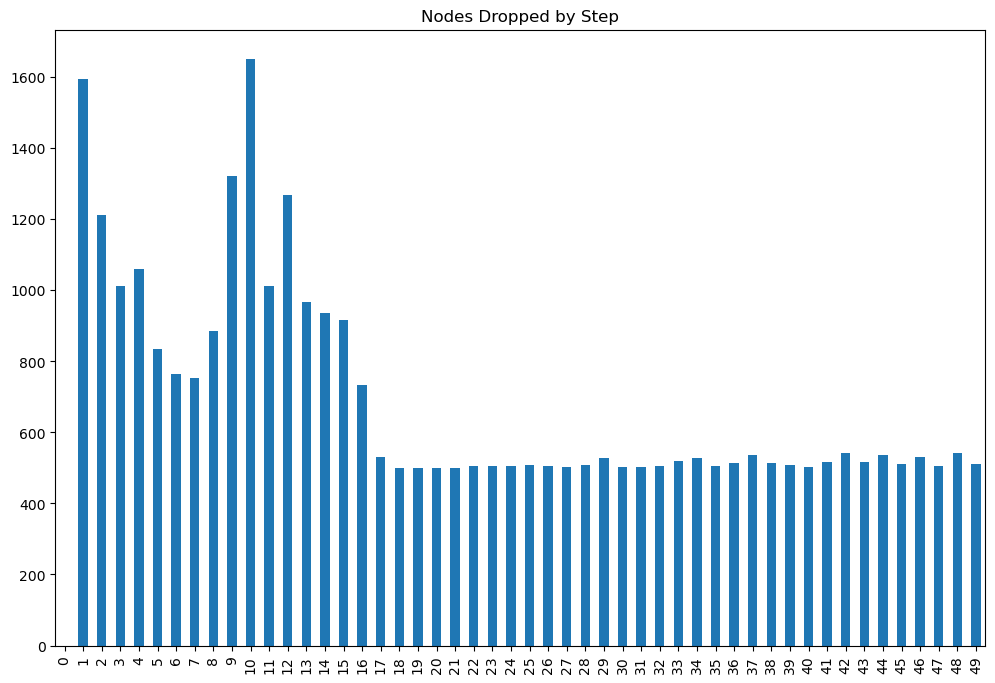

In [20]:
_= result_df['nodes_dropped'].plot.bar(figsize=(12,8), title='Nodes Dropped by Step')

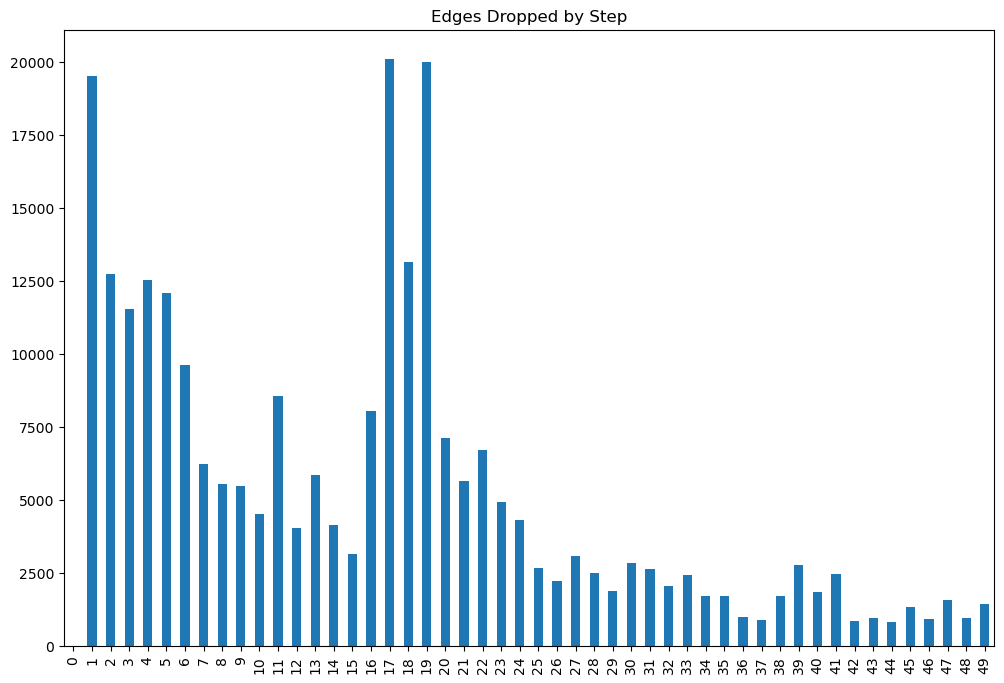

In [21]:
_= result_df['edges_dropped'].plot.bar(figsize=(12,8), title='Edges Dropped by Step')

In [22]:
# learning at each iteration
# speeding up at each step, because smaller networks
# betweenness centrality and shortest path related things are very slow on larger networks
# pagerank can be used instead
# use a centrality that can determine importance beyond number of edges; goal is to cut bridge nodes
# attack options are only limited by creativity

# on complex network, might need larger cut sizes to be effective
# goal was to shatter the network as quickly as possible

# collaborative networks seem to be more resilient in nature; considering that some papers have dozens of authors

# Investigate Surviving Structures

In [23]:
def show_component_count(components, cutoff=4):

    i = 0
    
    for c in components:
        
        if len(c) > cutoff:

            print('c: {} - len: {}'.format(i, len(c)))

        i += 1

In [24]:
def draw_component(G, component, show_names=False):
    
    G = G.copy()

    G_check = G.subgraph(component)

    return draw_graph(G_check, show_names=show_names, node_size=3)

In [25]:
components = list(nx.connected_components(G))
len(components)

4848

In [26]:
show_component_count(components, 40)

c: 0 - len: 76
c: 1 - len: 32185
c: 189 - len: 49
c: 309 - len: 44
c: 463 - len: 50
c: 607 - len: 86
c: 649 - len: 62
c: 653 - len: 120
c: 810 - len: 42
c: 1012 - len: 73
c: 1061 - len: 57
c: 1073 - len: 47


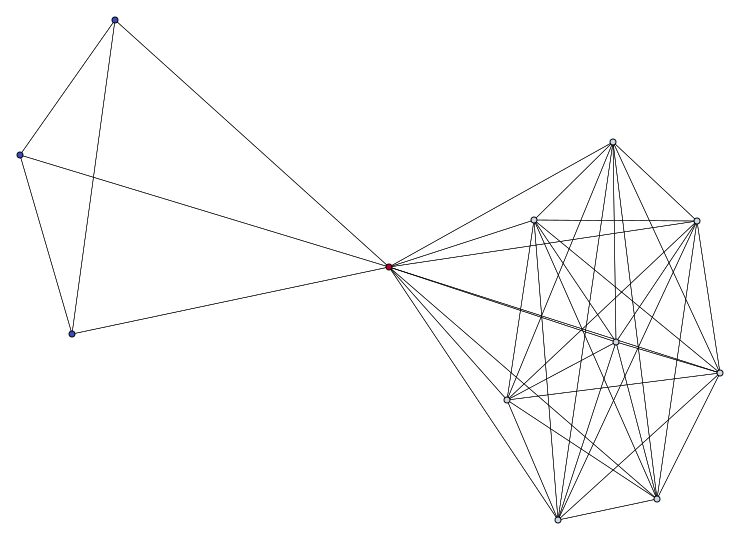

In [27]:
component = components[816]

draw_component(G, component)

In [28]:
components = list(nx.connected_components(G1))
len(components)

6363

In [29]:
show_component_count(components, 9)

c: 50 - len: 10
c: 53 - len: 10
c: 89 - len: 10
c: 673 - len: 10
c: 891 - len: 10
c: 928 - len: 10
c: 949 - len: 10
c: 1025 - len: 10
c: 1358 - len: 10
c: 1386 - len: 10
c: 1462 - len: 10
c: 1816 - len: 10
c: 2395 - len: 10
c: 2407 - len: 10
c: 2629 - len: 10
c: 2686 - len: 10
c: 2859 - len: 10
c: 3004 - len: 10
c: 3084 - len: 10
c: 3119 - len: 10
c: 3146 - len: 10
c: 3502 - len: 10
c: 4968 - len: 10
c: 5266 - len: 10
c: 5298 - len: 10


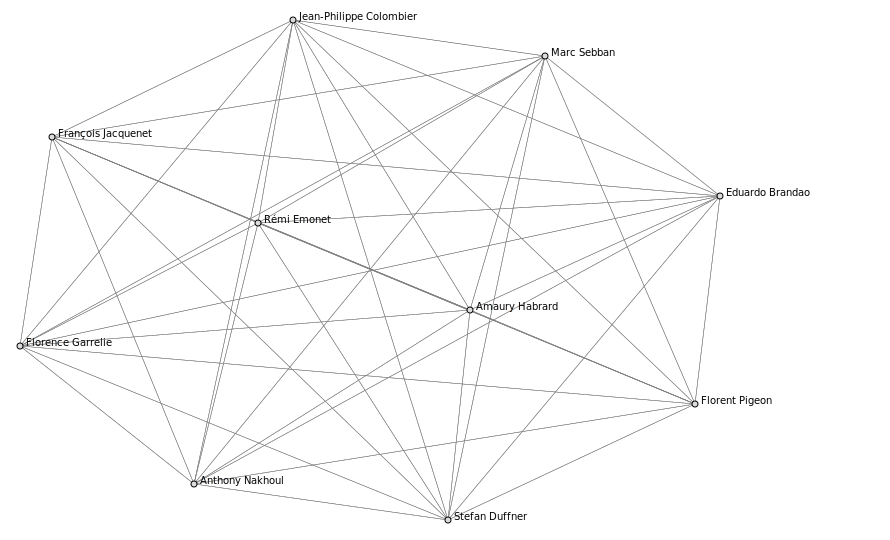

In [30]:
component = components[53]

draw_component(G1, component, show_names=True)

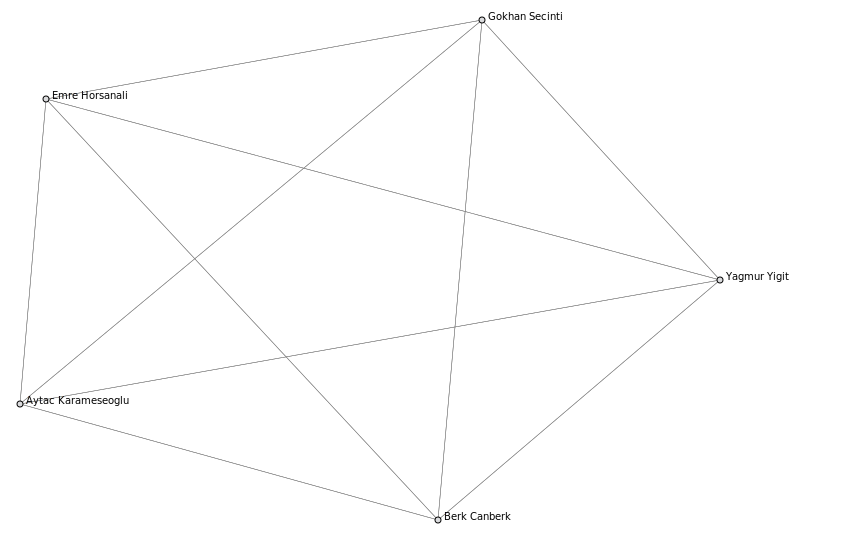

In [31]:
component = components[56]

draw_component(G1, component, show_names=True)

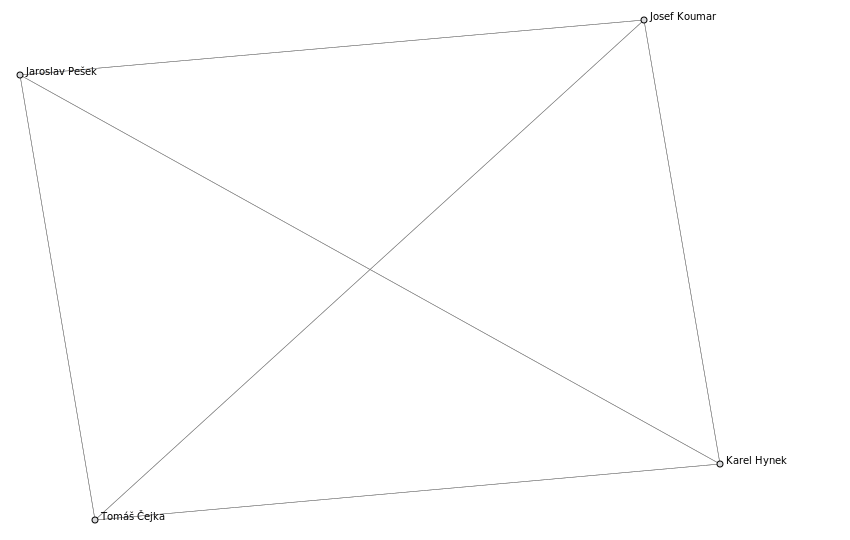

In [32]:
component = components[92]

draw_component(G1, component, show_names=True)

In [33]:
print(G)

Graph with 59260 nodes and 302588 edges


In [34]:
print(G1)

Graph with 24893 nodes and 41180 edges


In [35]:
nx.density(G) # very sparse

0.00017233192168756068

In [36]:
nx.density(G1) # very sparse

0.00013291662540323073

In [37]:
degree_df = pd.DataFrame(G.degree)
degree_df.columns = ['node', 'degrees']

degree_df.head()

,node,degrees
0,Dustin Nguyen,4
1,Yuan-Sen Ting,36
2,Todd A. Thompson,4
3,Sebastian Lopez,4
4,Laura A. Lopez,4


<Axes: ylabel='Frequency'>

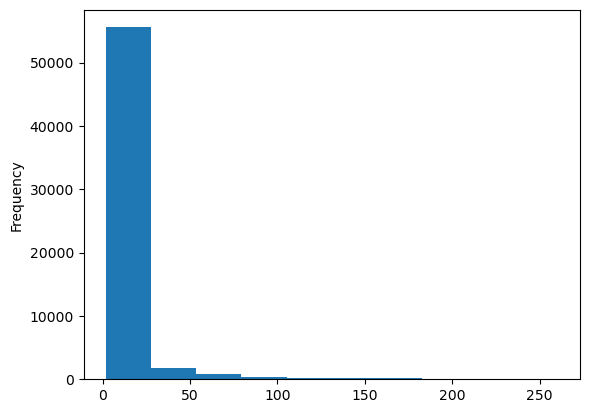

In [38]:
degree_df['degrees'].plot.hist()

In [39]:
degree_df = pd.DataFrame(G1.degree)
degree_df.columns = ['node', 'degrees']

degree_df.head()

,node,degrees
0,Purvik Patel,2
1,Franc O,2
2,Jonathan Blazek,2
3,Lorenz Kummer,3
4,Samir Moustafa,3


<Axes: ylabel='Frequency'>

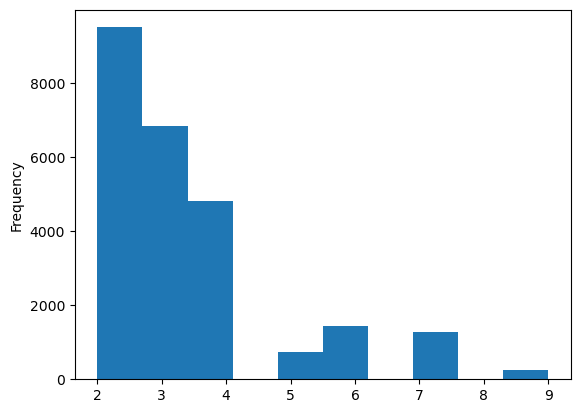

In [40]:
degree_df['degrees'].plot.hist()

In [41]:
nodes = [len(G.nodes), len(G1.nodes)]
edges = [len(G.edges), len(G1.edges)]

<Axes: >

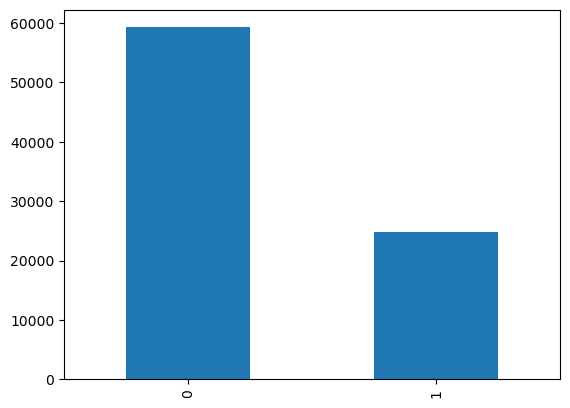

In [42]:
final_df = pd.DataFrame({'nodes':nodes, 'edges':edges})
final_df.sort_index(ascending=True, inplace=True)

final_df['nodes'].plot.bar()

<Axes: >

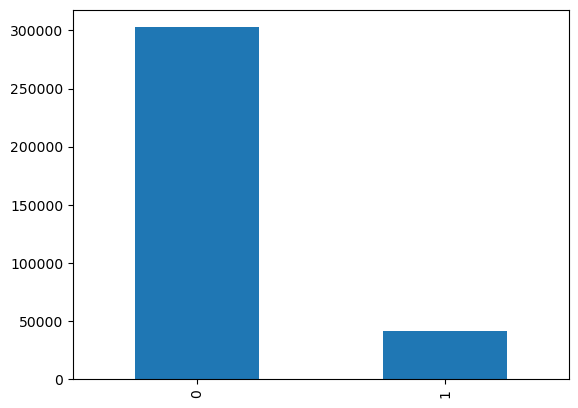

In [43]:
final_df['edges'].plot.bar()

In [44]:
final_df

,nodes,edges
0,59260,302588
1,24893,41180
